In [165]:
import cv2
import glob
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [183]:
def data_loader(file_names):
    hue=[]
    sat=[]
    val=[]
    sq_size=[]
    for f in file_names:
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (256, 256))
        mask = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 0,1, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        img_mask = img * np.repeat(mask[:,:,np.newaxis],3,axis=2)

        _, _, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8) 
        sq_size.append(np.max(stats[1,-1])) 

        hue_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[...,0]
        hue.append(np.median(hue_img[mask>0]))

        sat_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[...,1]
        sat.append(np.median(sat_img[mask>0]))

        val_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[...,2]
        val.append(np.median(val_img[mask>0]))

    return hue, sat, val, sq_size

In [184]:
hue_a, sat_a, val_a, sq_size_a = data_loader(file_names=glob.glob(r'squares/train/a/*.[pjbt][npmi][ggpf]*'))
hue_b, sat_b, val_b, sq_size_b = data_loader(file_names=glob.glob(r'squares/train/b/*.[pjbt][npmi][ggpf]*'))
hue_c, sat_c, val_c, sq_size_c = data_loader(file_names=glob.glob(r'squares/train/c/*.[pjbt][npmi][ggpf]*'))

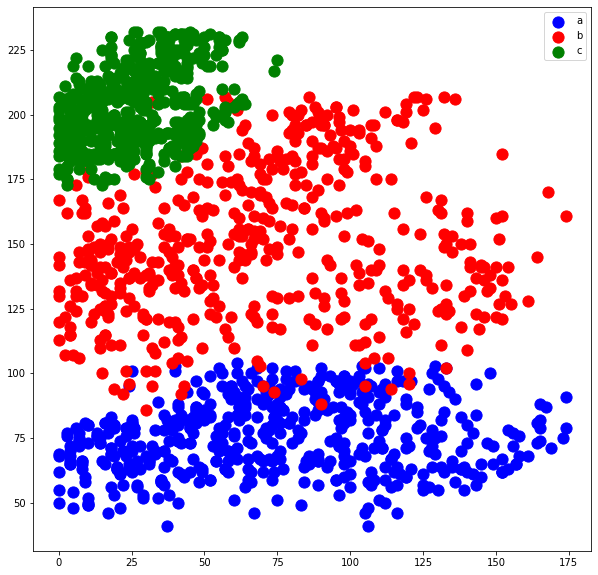

In [188]:
plt.subplots(figsize=(10, 10))
p1=plt.scatter(x=np.array(sat_a) , y=np.array(val_a), marker='.', s=500, c='blue')
p2=plt.scatter(x=np.array(sat_b) , y=np.array(val_b), marker='.', s=500, c='red')
p3=plt.scatter(x=np.array(sat_c) , y=np.array(val_c), marker='.', s=500, c='green')
plt.legend((p1,p2,p3),('a','b','c'))


In [198]:
sat_all = np.array([sat_a+sat_b+sat_c])
val_all = np.array([val_a+val_b+val_c])
features = np.concatenate([sat_all,val_all],axis=0).transpose()
target = np.array([1]*len(sat_a) + [2]*len(sat_b) + [3]*len(sat_c) )
print(features.shape, target.shape)

(1500, 2) (1500,)


In [201]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(features, target)
predictions = clf.predict(features)
print(clf.score(features, target).round(4))


0.9973


In [204]:
hue_a_test, sat_a_test, val_a_test, sq_size_a_test = data_loader(file_names=glob.glob(r'squares/val/a/*.[pjbt][npmi][ggpf]*'))
hue_b_test, sat_b_test, val_b_test, sq_size_b_test = data_loader(file_names=glob.glob(r'squares/val/b/*.[pjbt][npmi][ggpf]*'))
hue_c_test, sat_c_test, val_c_test, sq_size_c_test = data_loader(file_names=glob.glob(r'squares/val/c/*.[pjbt][npmi][ggpf]*'))

In [206]:
sat_all_test = np.array([sat_a_test+sat_b_test+sat_c_test])
val_all_test = np.array([val_a_test+val_b+val_c_test])
features_test = np.concatenate([sat_all_test,val_all_test],axis=0).transpose()
target_test = np.array([1]*len(sat_a_test) + [2]*len(sat_b_test) + [3]*len(sat_c_test) )
print(features_test.shape, target_test.shape)

(1500, 2) (1500,)


In [215]:
predictions = clf.predict(features_test)
print(clf.score(features_test, target_test))

0.944


In [253]:
from sklearn.metrics import average_precision_score, precision_recall_curve

target_test_one_hot = np.zeros((target_test.shape[0],3))
predictions_one_hot = np.zeros((predictions.shape[0],3))    
average_precision = dict()
precision = dict()
recall = dict()

for i in range(3):
    target_test_one_hot[:,i] = target_test==i+1
    predictions_one_hot[:,i] = predictions==i+1
    precision[i], recall[i], _ = precision_recall_curve(target_test_one_hot[:,i], 
                                                        predictions_one_hot[:,i])
    average_precision[i] = average_precision_score(target_test_one_hot[:,i], 
                                                   predictions_one_hot[:,i])
# mAP
precision["mAP"], recall["mAP"], _ = precision_recall_curve(target_test_one_hot.ravel(), 
                                                                predictions_one_hot.ravel())
average_precision["mAP"] = average_precision_score(target_test_one_hot, predictions_one_hot, average="micro")

In [254]:
average_precision

{0: 0.9423655913978495,
 1: 0.8726553672316385,
 2: 0.9153483709273182,
 'mAP': 0.9098026666666666}

In [257]:
print(f'mAP: {average_precision["mAP"]:.3f}')

mAP: 0.910
